In [34]:
import numpy as np
from wLSM_utils import *
from graspy.simulations import sbm
from graspy.embed import AdjacencySpectralEmbed as ASE
from graspy.cluster import GaussianCluster as GCLUST
import matplotlib.pyplot as plt

%matplotlib inline
from itertools import combinations
from scipy.stats import norm
import scipy.optimize as optimize

# %matplotlib inline

In [2]:
def generate_cyclops(X, n, pi, density=None, density_params=[0,1], acorn=None):
    if acorn is None:
        acorn = np.random.randint(10**6)
    np.random.seed(acorn)
    
    counts = np.random.multinomial(n, [pi, 1 - pi]).astype(int)
    
    if density is None:
        density = np.random.uniform
        U = sample(counts[0], density, density_params)
        X_L = get_latent_positions(U)
    else:
#         U = sample(counts[0], density, density_params)
        density_params = np.array(density_params)
        d = len(density_params)
        if density_params.ndim == 1:
            pass
        else:
            X_temp = np.stack([sample(counts[0], density, density_params[i]) for i in range(d)], axis=1)
            quad = np.sum(np.array([3, 3])*X_temp[:,:2]**2, axis=1)[:, np.newaxis]
            print(quad, X_temp[0, 0], X_temp[0, 1], X_temp[0, 0]**2 + X_temp[0, 1]**2)
            X_L = np.concatenate((X_temp[:,:2], quad), axis=1)
        
    X = X[:, np.newaxis].T
    
    All_X = np.concatenate((X_L, X), axis = 0)
    
    P = All_X @ All_X.T
    
    A = sbm(np.concatenate((np.ones(counts[0]).astype(int), [counts[1]])), P)
    
    return A, counts

In [3]:
X = np.array([0.2, 0.2, 0.2])
density = np.random.uniform
density_params = np.array([[0.3, 0.4],[0.3, 0.35]])

n = 1000
pi = 0.9

A, counts = generate_cyclops(X, n, pi, None)
c = ['b']*counts[0]
c += ['r']*counts[1]

In [18]:
ase = ASE(n_components=3)
X_hat = ase.fit_transform(A)
%matplotlib notebook
import matplotlib.pyplot as plt

<IPython.core.display.Javascript object>


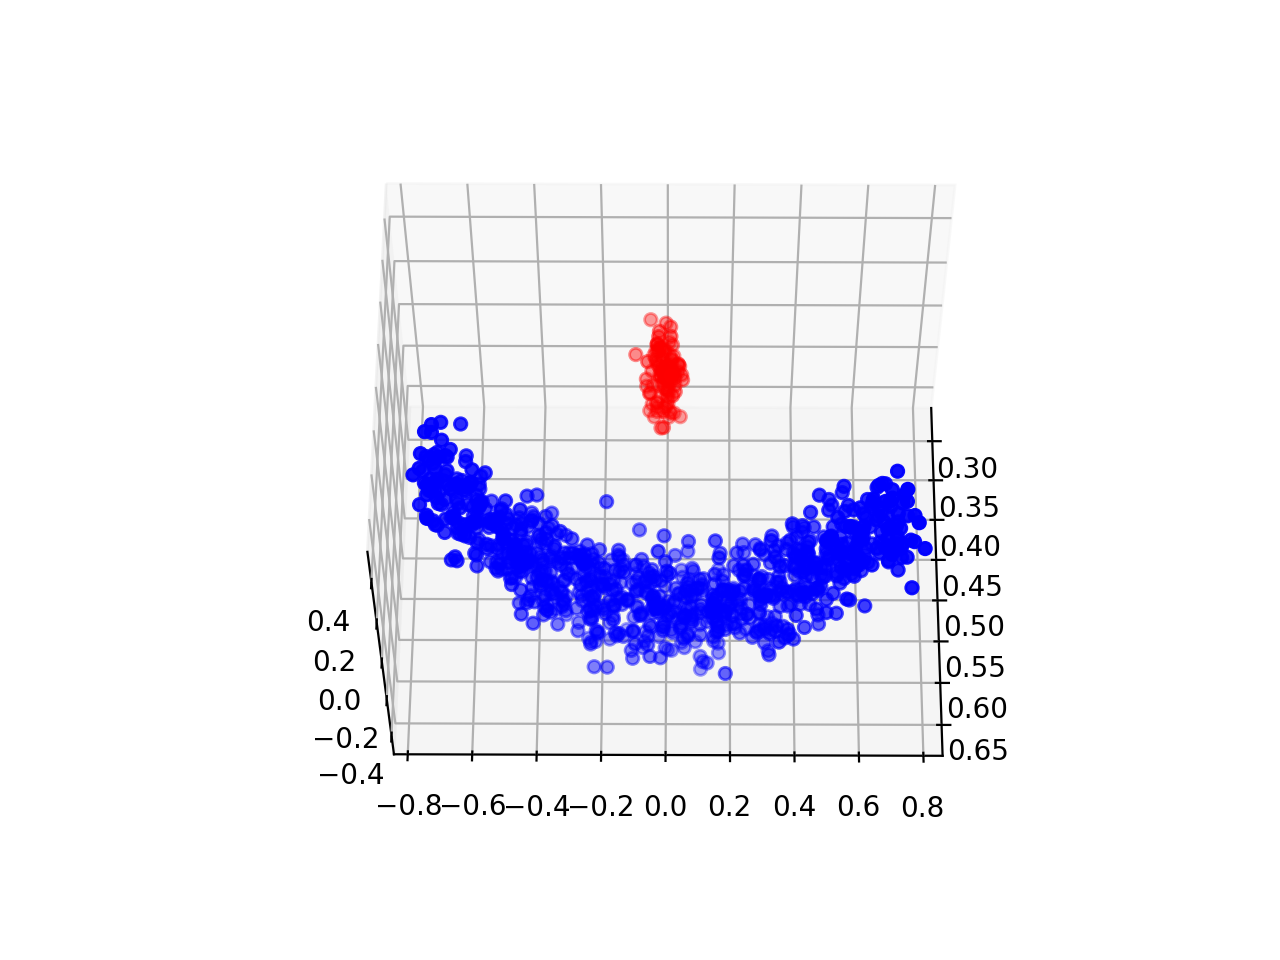

In [19]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X_hat[:, 0], X_hat[:, 1], X_hat[:, 2], c=c)
# ax.scatter(A[:, 0], A[:, 1], A[:, 2])#, c=c)


In [6]:
gclust = GCLUST(min_components=4)
c_hat = gclust.fit_predict(X_hat)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X_hat[:, 0], X_hat[:, 1], X_hat[:, 2], c=c_hat)

TypeError: __init__() got an unexpected keyword argument 'min_components'

In [36]:
def quadratic(data, params):
    if data.ndim == 1:
        sum_ = np.sum(data[:-1]**2 * params[:-1]) + params[-1]
        return sum_
    elif data.ndim == 2:
        sums = np.sum(data[:, :-1]**2 * params[:-1], axis = 1) + params[-1]
        return sums
    else:
        raise ValueError("unsuppored data")
        
def quadratic_log_likelihood(data, params):
    n, d = data.shape
    fitted_Z = quadratic(data, params)
    residuals = fitted_Z - data[:, -1] # assuming data.ndim == 2
    std = np.std(residuals, ddof=1)
    
    log_likelihood = 0
    for i in range(n):
        log_likelihood += np.log(norm.pdf(residuals[i], fitted_Z[i], std))
        
    return log_likelihood

def func(data, a, b, c):
    return a*(data[:, 0])**2 + b*data[:, 1]**2 + c

In [ ]:
unique_labels = np.unique(c_hat)
K = len(unique_labels)

guess = (1,1,1)
params, pcov = optimize.curve_fit(func, X_hat[:, :2], X_hat[:, 2], guess)

class_idx = np.array([np.where(c_hat == u)[0] for u in unique_labels])

loglikelihoods = [np.sum(gclust.model_.score_samples(X_hat))]

# Plot for each fitted quad
for k in range(len(unique_labels)):
    for combo in list(combinations(np.unique(c_hat), k+1)):
        combo = np.array(list(combo)).astype(int)
        print(combo)
        temp_quad_labels = np.concatenate(class_idx[combo])
        temp_n = len(temp_quad_labels)
        
        maxes = np.array([max(X_hat[temp_quad_labels, i]) for i in range(X_hat.shape[1] - 1)])
        mins = np.array([min(X_hat[temp_quad_labels, i]) for i in range(X_hat.shape[1] - 1)])
        area = np.prod(maxes - mins)
        log_A = temp_n * np.log(1/area)
        
        guess = (1,1,1)
        params, pcov = optimize.curve_fit(func, X_hat[temp_quad_labels, :2], X_hat[temp_quad_labels, 2], guess)
        
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')
        
        fitted_Z = quadratic(X_hat, params)
        temp_Z = X_hat[:, 2].copy()
        temp_Z[temp_quad_labels] = fitted_Z[temp_quad_labels]
        
        temp_c = np.array(['r']*n)
        temp_c[temp_quad_labels] = ['b']
        ax.scatter(X_hat[:, 0], X_hat[:, 1], temp_Z, c=temp_c)
        
        quad_log_likelihood = quadratic_log_likelihood(X_hat[temp_quad_labels], params)
        gmm_log_likelihood = np.sum(gclust.model_.score_samples(X_hat[-temp_quad_labels]))
        
        loglikelihoods.append(quad_log_likelihood + gmm_log_likelihood + log_A)

In [ ]:
fig, ax = plt.subplots(1,1)
ax.plot(np.arange(2**K), loglikelihoods)

In [12]:
from graspy.datasets import load_drosophila_left, load_drosophila_right
from graspy.utils import binarize

left_adj, left_labels = load_drosophila_left(return_labels=True)
right_adj, right_labels = load_drosophila_right(return_labels=True)

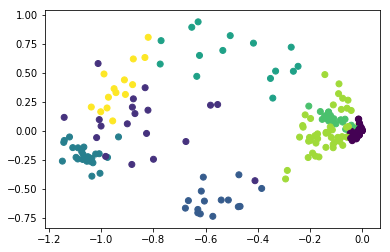

In [54]:
A_right = binarize(right_adj)
X_hat_right = ASE(n_components=3).fit_transform(A_right)[0]
gclust_right = GCLUST(max_components=8)
c_hat_right = gclust_right.fit_predict(X_hat_right)

fig, ax = plt.subplots(1,1)
ax.scatter(-X_hat_right[:, 0], X_hat_right[:, 1], c=c_hat_right)

<IPython.core.display.Javascript object>


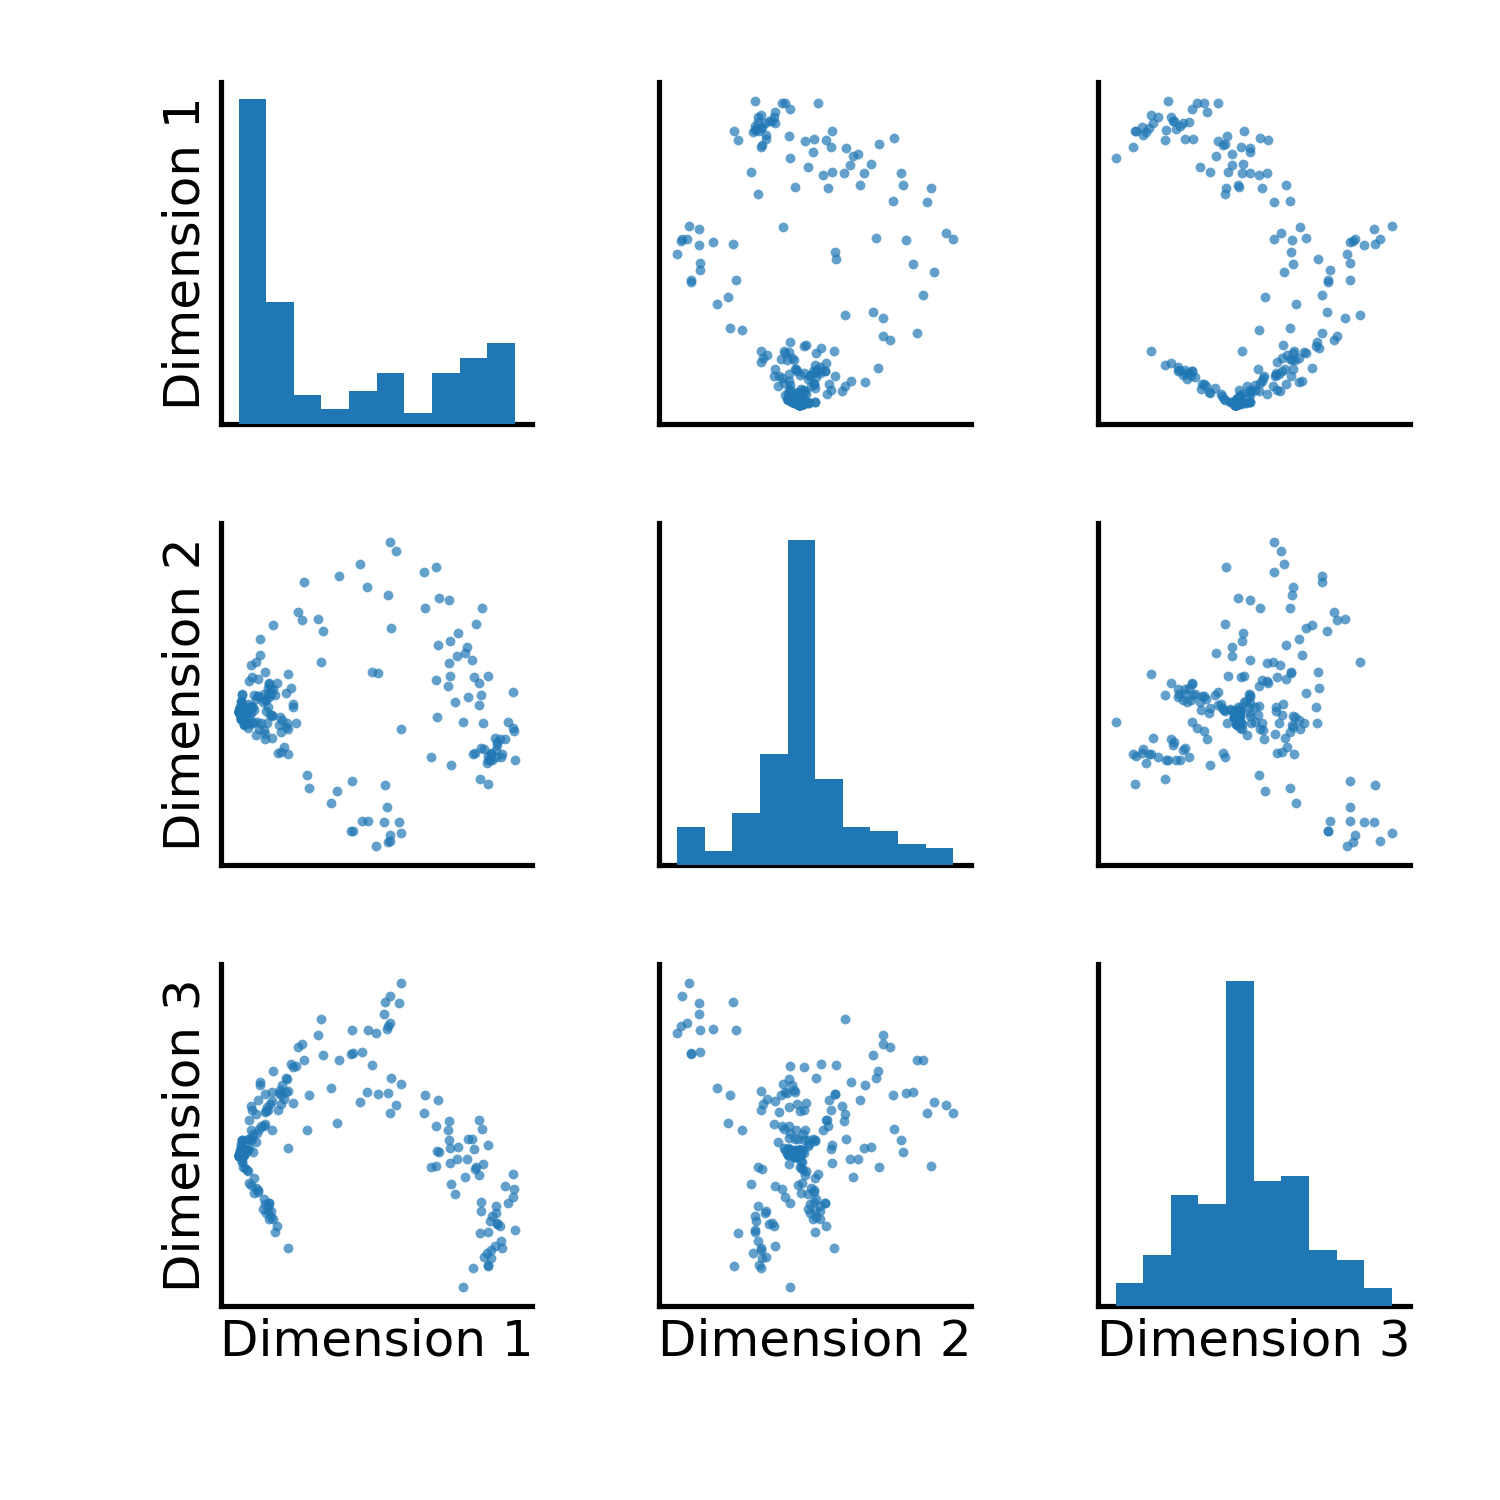

In [28]:
pairplot(X_hat_right)

In [40]:
unique_labels = np.unique(c_hat_right)
K = len(unique_labels)

guess = (1,1,1)
params, pcov = optimize.curve_fit(func, X_hat_right[:, :2], X_hat_right[:, 2], guess)

class_idx = np.array([np.where(c_hat_right == u)[0] for u in unique_labels])

loglikelihoods_right = [np.sum(gclust_right.model_.score_samples(X_hat_right))]
combos = []

# Plot for each fitted quad
for k in range(len(unique_labels)):
    for combo in list(combinations(np.unique(c_hat_right), k+1)):
        combo = np.array(list(combo)).astype(int)
        combos.append(combo)
        print(combo)
        temp_quad_labels = np.concatenate(class_idx[combo])
        temp_n = len(temp_quad_labels)
        
        maxes = np.array([max(X_hat[temp_quad_labels, i]) for i in range(X_hat_right.shape[1] - 1)])
        mins = np.array([min(X_hat[temp_quad_labels, i]) for i in range(X_hat_right.shape[1] - 1)])
        area = np.prod(maxes - mins)
        log_A = temp_n * np.log(1/area)
        
        guess = (1,1,1)
        params, pcov = optimize.curve_fit(func, X_hat_right[temp_quad_labels, :2], X_hat_right[temp_quad_labels, 2], guess)
        
#         fig = plt.figure()
#         ax = fig.add_subplot(111, projection='3d')
        
        fitted_Z = quadratic(X_hat_right, params)
        temp_Z = X_hat_right[:, 2].copy()
        temp_Z[temp_quad_labels] = fitted_Z[temp_quad_labels]
        
        temp_c = np.array(['r']*n)
        temp_c[temp_quad_labels] = ['b']
#         ax.scatter(X_hat[:, 0], X_hat[:, 1], temp_Z, c=temp_c)
        
        quad_log_likelihood = quadratic_log_likelihood(X_hat_right[temp_quad_labels], params)
        gmm_log_likelihood = np.sum(gclust_right.model_.score_samples(X_hat_right[-temp_quad_labels]))
        
        loglikelihoods_right.append(quad_log_likelihood + gmm_log_likelihood + log_A)

[0]
[1]
[2]
[3]
[4]
[5]
[6]
[0 1]
[0 2]
[0 3]
[0 4]
[0 5]
[0 6]
[1 2]
[1 3]
[1 4]
[1 5]
[1 6]
[2 3]
[2 4]
[2 5]
[2 6]
[3 4]
[3 5]
[3 6]
[4 5]
[4 6]
[5 6]
[0 1 2]
[0 1 3]
[0 1 4]
[0 1 5]
[0 1 6]
[0 2 3]
[0 2 4]
[0 2 5]
[0 2 6]
[0 3 4]
[0 3 5]
[0 3 6]
[0 4 5]
[0 4 6]
[0 5 6]
[1 2 3]
[1 2 4]
[1 2 5]
[1 2 6]
[1 3 4]
[1 3 5]
[1 3 6]
[1 4 5]
[1 4 6]
[1 5 6]
[2 3 4]
[2 3 5]
[2 3 6]
[2 4 5]
[2 4 6]
[2 5 6]
[3 4 5]
[3 4 6]
[3 5 6]
[4 5 6]
[0 1 2 3]
[0 1 2 4]
[0 1 2 5]
[0 1 2 6]
[0 1 3 4]
[0 1 3 5]
[0 1 3 6]
[0 1 4 5]
[0 1 4 6]
[0 1 5 6]
[0 2 3 4]
[0 2 3 5]
[0 2 3 6]
[0 2 4 5]
[0 2 4 6]
[0 2 5 6]
[0 3 4 5]
[0 3 4 6]
[0 3 5 6]
[0 4 5 6]
[1 2 3 4]
[1 2 3 5]
[1 2 3 6]
[1 2 4 5]
[1 2 4 6]
[1 2 5 6]
[1 3 4 5]
[1 3 4 6]
[1 3 5 6]
[1 4 5 6]
[2 3 4 5]
[2 3 4 6]
[2 3 5 6]
[2 4 5 6]
[3 4 5 6]
[0 1 2 3 4]
[0 1 2 3 5]
[0 1 2 3 6]
[0 1 2 4 5]
[0 1 2 4 6]
[0 1 2 5 6]
[0 1 3 4 5]
[0 1 3 4 6]
[0 1 3 5 6]
[0 1 4 5 6]
[0 2 3 4 5]
[0 2 3 4 6]
[0 2 3 5 6]
[0 2 4 5 6]
[0 3 4 5 6]
[1 2 3 4 5]
[1 2 3 4 6]
[1 2 3 5 6]


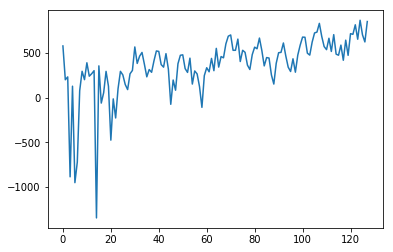

In [39]:
fig, ax = plt.subplots(1,1)
ax.plot(np.arange(2**K), loglikelihoods_right)

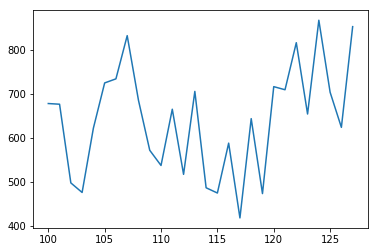

In [46]:
fig, ax = plt.subplots(1,1)
ax.plot(np.arange(100, len(combos) + 1), loglikelihoods_right[100:])

In [48]:
for i in range(len(combos[100:])):
    print(i, combos[100 + i])

0 [0 1 2 3 6]
1 [0 1 2 4 5]
2 [0 1 2 4 6]
3 [0 1 2 5 6]
4 [0 1 3 4 5]
5 [0 1 3 4 6]
6 [0 1 3 5 6]
7 [0 1 4 5 6]
8 [0 2 3 4 5]
9 [0 2 3 4 6]
10 [0 2 3 5 6]
11 [0 2 4 5 6]
12 [0 3 4 5 6]
13 [1 2 3 4 5]
14 [1 2 3 4 6]
15 [1 2 3 5 6]
16 [1 2 4 5 6]
17 [1 3 4 5 6]
18 [2 3 4 5 6]
19 [0 1 2 3 4 5]
20 [0 1 2 3 4 6]
21 [0 1 2 3 5 6]
22 [0 1 2 4 5 6]
23 [0 1 3 4 5 6]
24 [0 2 3 4 5 6]
25 [1 2 3 4 5 6]
26 [0 1 2 3 4 5 6]


In [50]:
combos[107], loglikelihoods_right[100+7]

(array([0, 1, 4, 5, 6]), 831.72146138186)

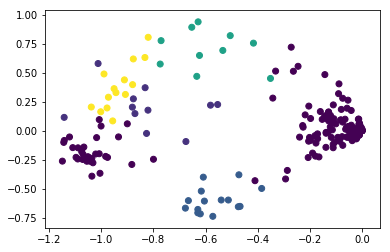

In [56]:
combo = combos[107]
temp_quad_labels = np.concatenate(class_idx[combo])
temp_label = min(combo)
temp_n = len(temp_quad_labels)

temp_c_hat = c_hat_right.copy()
temp_c_hat[temp_quad_labels] = temp_label

maxes = np.array([max(X_hat[temp_quad_labels, i]) for i in range(X_hat_right.shape[1] - 1)])
mins = np.array([min(X_hat[temp_quad_labels, i]) for i in range(X_hat_right.shape[1] - 1)])
area = np.prod(maxes - mins)
log_A = temp_n * np.log(1/area)

guess = (1,1,1)
params, pcov = optimize.curve_fit(func, X_hat_right[temp_quad_labels, :2], X_hat_right[temp_quad_labels, 2], guess)

fig, ax = plt.subplots(1,1)
ax.scatter(-X_hat_right[:, 0], X_hat_right[:, 1], c=temp_c_hat)

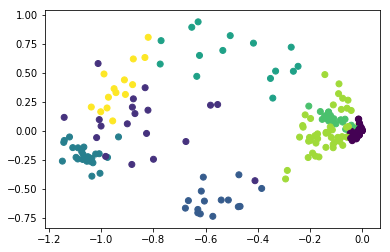

In [55]:
fig, ax = plt.subplots(1,1)
ax.scatter(-X_hat_right[:, 0], X_hat_right[:, 1], c=c_hat_right)